In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import multiprocessing as mp

from utils import *
from exp_utils import *
from tests import *
from cd_models import *

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

%config InlineBackend.figure_format = 'retina'

In [2]:
B=100
n_p=200 #number of simulations used to estimate power
alpha=.05
perc=list(range(20,100,20)) #percentiles for binning
n = 1000
lamb = .24
task='reg'
test=.5

In [3]:
def GenNoise(n,d):
    data=pd.DataFrame(np.random.normal(0,1,(d-1)*n).reshape((n,d-1)))
    data.columns=['x'+str(i) for i in range(1,data.shape[1]+1)]
    return data

## Ours

In [4]:
pvals_ours=[]

d_ours=[1,2,3,4, 10,20,30,40, 100,200,300,400]

for d in d_ours:
    for k in tqdm(range(n_p)):
        for theta in [0]:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, _, _, _, _, \
            Xt_train, Xt_test, _, _, _, _ = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)
            n_train=int((1-test)*n)
            Xs_train=pd.concat([Xs_train.reset_index(drop=True), GenNoise(n_train,d).reset_index(drop=True)], axis=1)
            Xt_train=pd.concat([Xt_train.reset_index(drop=True), GenNoise(n_train,d).reset_index(drop=True)], axis=1)
            n_test=int(test*n)
            Xs_test=pd.concat([Xs_test.reset_index(drop=True), GenNoise(n_test,d).reset_index(drop=True)], axis=1)
            Xt_test=pd.concat([Xt_test.reset_index(drop=True), GenNoise(n_test,d).reset_index(drop=True)], axis=1)
            
            ### P-values ###
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)
            cov=Permut(Xs_test, Xt_test, covshift_model, B=B, verbose=False)
            pval_kl = cov['pval']
            pvals_ours.append([d,pval_kl])
            
pvals_ours=np.array(pvals_ours)

100%|█████████████████████████████████████████| 200/200 [00:24<00:00,  8.17it/s]


In [5]:
power_ours=[]

for d in d_ours:   
    ind=pvals_ours[:,0]==d
    power_ours.append([d,np.mean(pvals_ours[ind,1]<alpha)])
    
power_ours=np.array(power_ours)

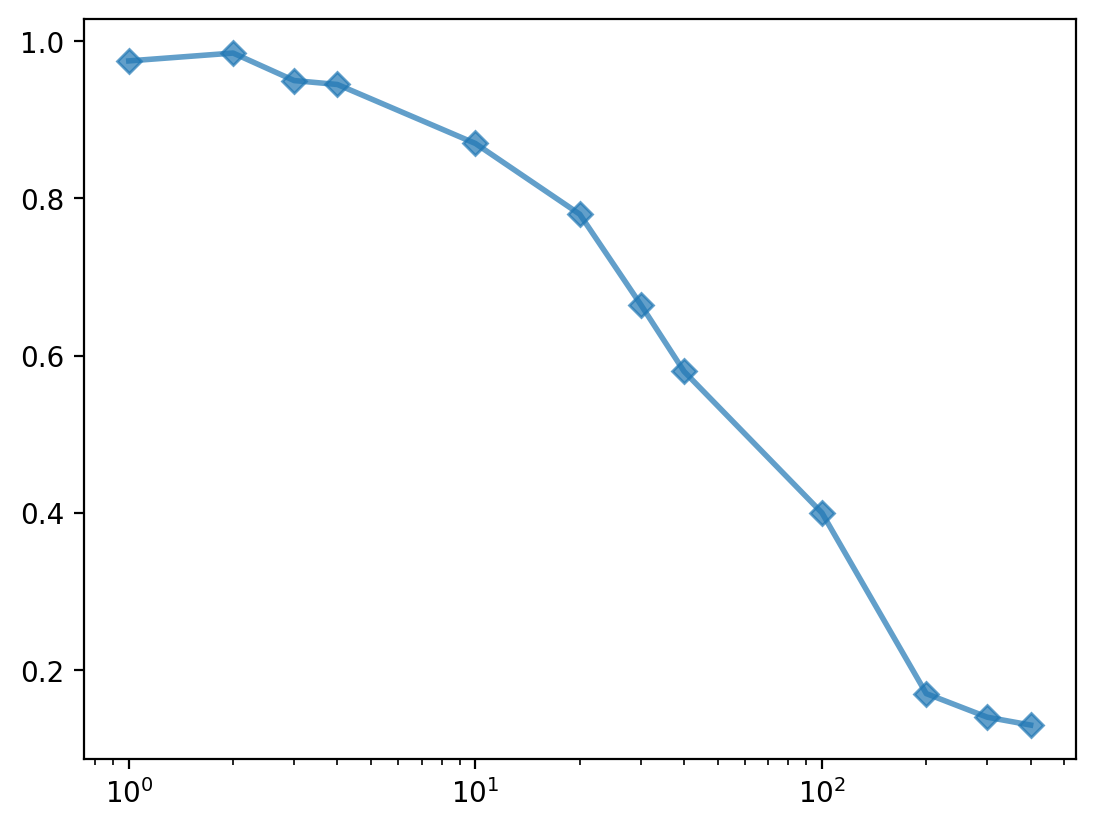

In [6]:
plt.plot([d for d in d_ours], power_ours[:,1],  marker="D", lw=2,alpha=.7, markersize=6)
plt.xscale('log')

## Class

In [7]:
pval_class=[]

for d in d_ours:
    for k in tqdm(range(n_p)):
        for theta in [0]:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, _, _, _, _, \
            Xt_train, Xt_test, _, _, _, _ = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)
            n_train=int((1-test)*n)
            Xs_train=pd.concat([Xs_train.reset_index(drop=True), GenNoise(n_train,d).reset_index(drop=True)], axis=1)
            Xt_train=pd.concat([Xt_train.reset_index(drop=True), GenNoise(n_train,d).reset_index(drop=True)], axis=1)
            n_test=int(test*n)
            Xs_test=pd.concat([Xs_test.reset_index(drop=True), GenNoise(n_test,d).reset_index(drop=True)], axis=1)
            Xt_test=pd.concat([Xt_test.reset_index(drop=True), GenNoise(n_test,d).reset_index(drop=True)], axis=1)
            
            ### Classifier ###
            
            pval_class.append([d,classifier_test(Xs_train, Xs_test, Xt_train, Xt_test)])
            
pval_class=np.array(pval_class)

100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.50it/s]


In [8]:
power_class=[]

for d in d_ours:   
    ind=pval_class[:,0]==d
    power_class.append([d,np.mean(pval_class[ind,1]<alpha)])
    
power_class=np.array(power_class)

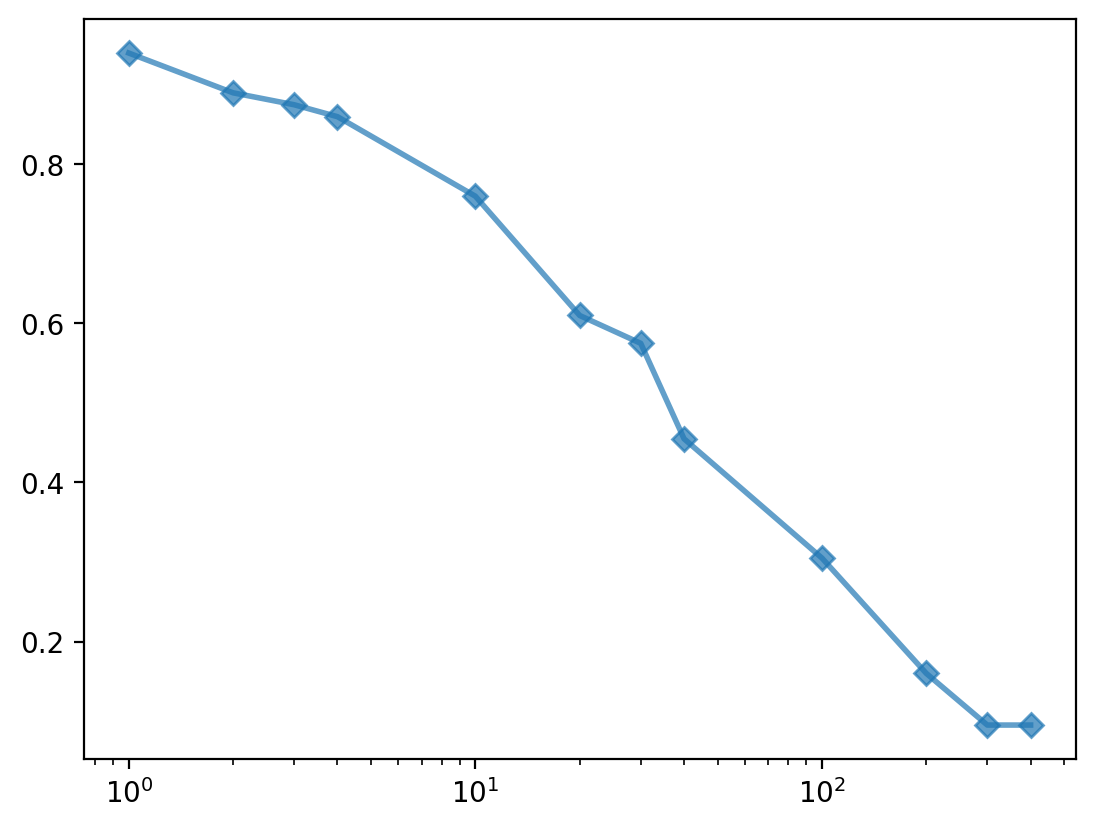

In [9]:
plt.plot([d for d in d_ours], power_class[:,1],  marker="D", lw=2,alpha=.7, markersize=6)
plt.xscale('log')

## TV

In [10]:
pvals_tv=[]

d_tv=[1,2,3,4]

for d in d_tv:
    for k in tqdm(range(n_p)):
        for theta in [0]:
                
            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs=np.hstack((Xs,np.array(GenNoise(n,d)))) 
            Xt=np.hstack((Xt,np.array(GenNoise(n,d))))
            Xbins = np.percentile(np.vstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)

            #Xs
            df = pd.DataFrame(Xs_bin, dtype='str')
            if d==1:
                df['concat'] = df[0]
            elif d==2:
                df['concat'] = df[0]+df[1]
            elif d==3:
                df['concat'] = df[0]+df[1]+df[2]
            elif d==4:
                df['concat'] = df[0]+df[1]+df[2]+df[3]
 
            Xs_bin=np.array(df['concat'], dtype='int')

            #Xt
            df = pd.DataFrame(Xt_bin, dtype='str')
            if d==1:
                df['concat'] = df[0]
            elif d==2:
                df['concat'] = df[0]+df[1]
            elif d==3:
                df['concat'] = df[0]+df[1]+df[2]
            elif d==4:
                df['concat'] = df[0]+df[1]+df[2]+df[3]

            Xt_bin=np.array(df['concat'], dtype='int')

            ### P-values ###
            pvals_tv.append([d,permut_test(tv,Xs_bin,Xt_bin,B)])
    
pvals_tv=np.array(pvals_tv)

100%|█████████████████████████████████████████| 200/200 [06:38<00:00,  1.99s/it]


In [11]:
power_tv=[]

for d in d_tv:   
    ind=pvals_tv[:,0]==d
    power_tv.append([d,np.mean(pvals_tv[ind,1]<alpha)])
    
power_tv=np.array(power_tv)

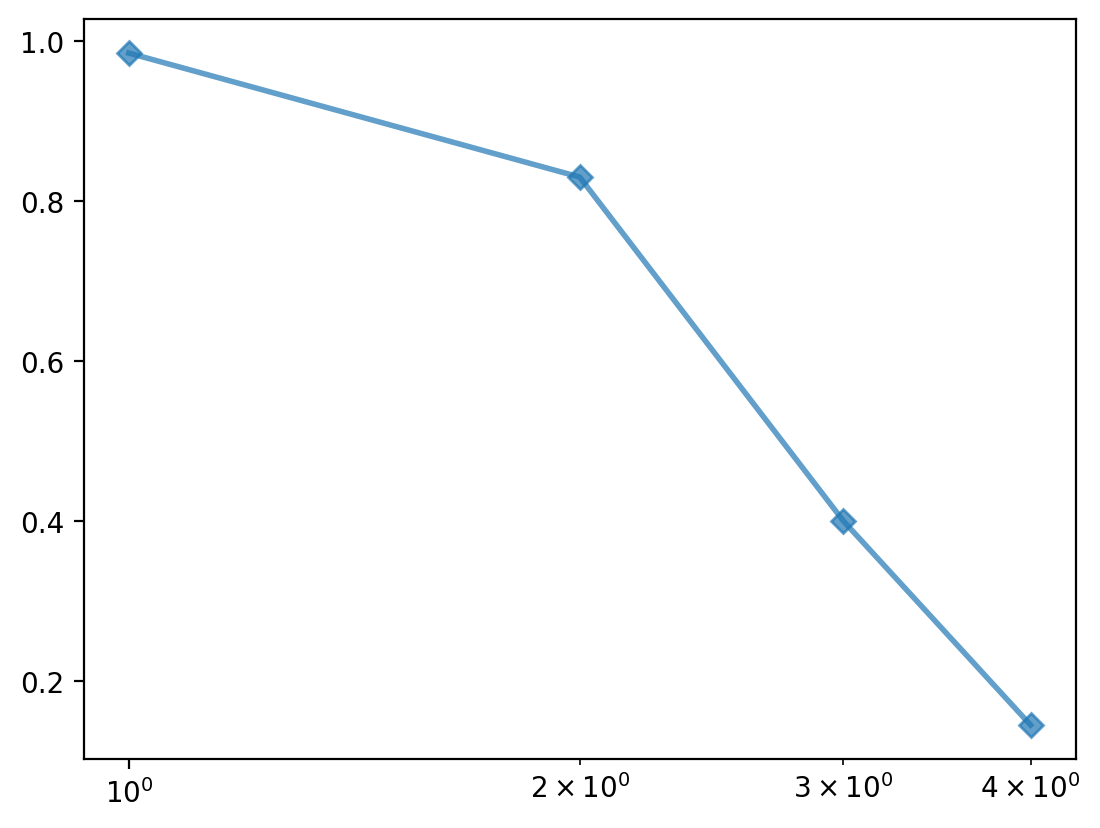

In [12]:
plt.plot([d for d in d_tv], power_tv[:,1],  marker="D", lw=2,alpha=.7, markersize=6)
plt.xscale('log')

## Saving

In [13]:
np.save('outputs/power_ours.npy', power_ours)
np.save('outputs/power_class.npy', power_class)
np.save('outputs/power_tv.npy', power_tv)

In [14]:
power_ours=np.load('outputs/power_ours.npy')
power_class=np.load('outputs/power_class.npy')
power_tv=np.load('outputs/power_tv.npy')

## Plots

In [15]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.05   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

In [16]:
colors = {'Z':'#2F58EB', 'KS':'#2F58EB', '$\chi^2$':'#773BEB', 'MMD':'#773BEB', 'Class.':'#12B8EB', 'Proba.':'#6D8AF1','TV':'#808080', 'KL (ours)':'#EB9846'}
markers = {'Z':"D", 'KS':"D", '$\chi^2$':"v", 'MMD':"v", 'Class.':"^", 'Proba.':"<",'TV':">", 'KL (ours)':"o"}

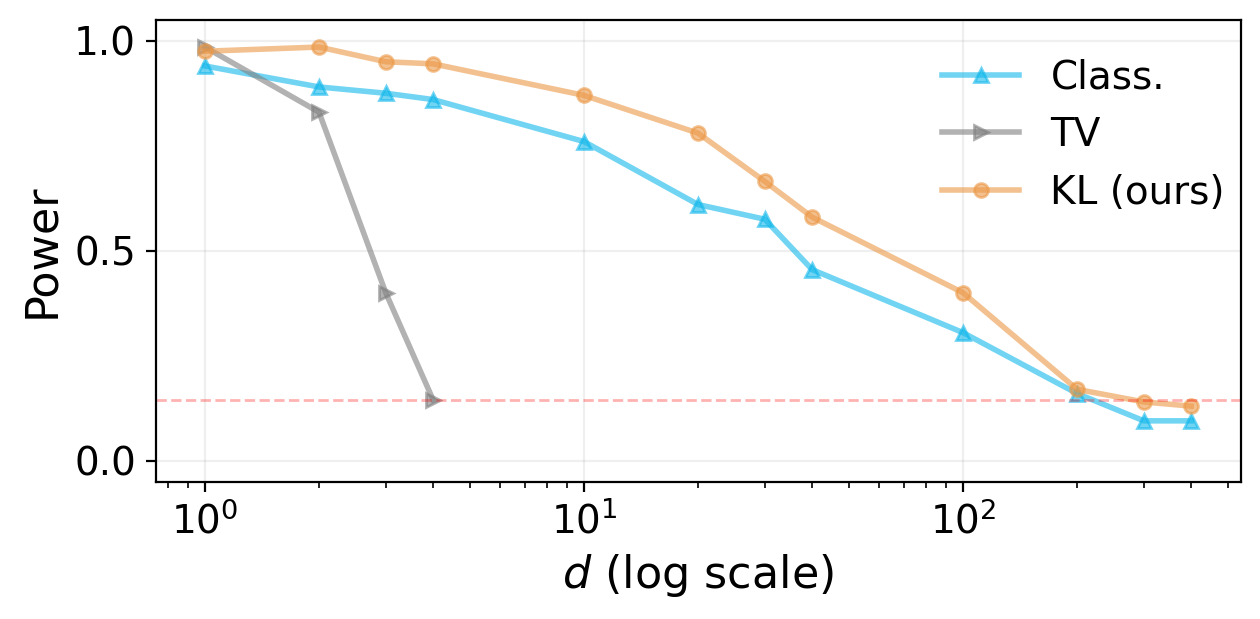

In [19]:
plt.figure(figsize=(7,3))

names=['MMD', 'Class.', 'TV', 'KL (ours)']

p=power_class[:,1]
err=np.sqrt(p*(1-p)/n_p)
x=[d for d in d_ours]
plt.plot(x, p, color=colors[names[1]], lw=2, label=names[1], marker=markers[names[1]], alpha=.6, markersize=5)
#plt.fill_between(x, p-err, p+err, color=colors[names[1]], alpha=.1)

p=power_tv[:,1]
err=np.sqrt(p*(1-p)/n_p)
x=[d for d in d_tv]
plt.plot(x, p, color=colors[names[2]], lw=2, label=names[2], marker=markers[names[2]], alpha=.6, markersize=5)
#plt.fill_between(x, p-err, p+err, color=colors[names[2]], alpha=.1)

p=power_ours[:,1]
err=np.sqrt(p*(1-p)/n_p)
x=[d for d in d_ours]
plt.plot(x, p, color=colors[names[3]], lw=2, label=names[3], marker=markers[names[3]], alpha=.6, markersize=5)
#plt.fill_between(x, p-err, p+err, color=colors[names[3]], alpha=.1)

plt.xscale('log')
plt.legend(bbox_to_anchor=(1, .95), loc='upper right', ncol = 1, prop={'size': 14}, borderaxespad=.0, frameon=False)       
plt.grid(alpha=.2)
plt.axhline(y=power_tv[-1,1], color='r', linestyle='--', lw=1, alpha=.3)
plt.ylabel('Power', size=16)
plt.ylim([-0.05,1.05])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$d$ (log scale)", size=16)
plt.locator_params(axis="y", nbins=4)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
plt.savefig('plots/dimensions.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()